In [1]:
import json
import matplotlib.pyplot as plt
import random
import requests
import time
import datetime
import uuid
import 

In [2]:
key_var_name = 'PERSONALIZER_KEY'
if not key_var_name in os.environ:
    raise Exception('Please set/export the environment variable: {}'.format(key_var_name))
personalizer_key = os.environ[key_var_name]

# Replace <your-resource-name>: https://<your-resource-name>.api.cognitive.microsoft.com/
endpoint_var_name = 'PERSONALIZER_ENDPOINT'
if not endpoint_var_name in os.environ:
    raise Exception('Please set/export the environment variable: {}'.format(endpoint_var_name))
personalizer_endpoint = os.environ[endpoint_var_name]

In [18]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    #print (str(currentDT))

In [19]:
# ititialize variable for model's last modified date
modelLastModified = ""

In [20]:
def get_last_updated(currentModifiedDate):

    print('-----checking model')

    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])

    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

In [21]:
def get_service_settings():

    print('-----checking service settings')

    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)

    print(response)
    print(response.json())

In [22]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.0/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.0/configurations/service"

headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# context
users = "users.json"

# action features
coffee = "coffee.json"

# empty JSON for Rank request
requestpath = "example-rankrequest.json"

# initialize random
random.seed(time.time())

userpref = None
rankactionsjsonobj = None
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(coffee) as handle:
    actionfeaturesobj = json.loads(handle.read())

with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())

get_last_updated(modelLastModified)
get_service_settings()

print(f'User count {len(userpref)}')
print(f'Coffee count {len(actionfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '2020-02-24T22:32:54+00:00', 'lastModifiedTime': '2020-02-25T04:12:57+00:00'}
-----model updated: "2020-02-25T04:12:57+00:00"
-----checking service settings
<Response [200]>
{'name': '7b90cd7609c345bca9e27db52868278e', 'arguments': '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr -q Fj -l 10 --power_t 0'}
<Response [200]>
{'rewardWaitTime': 'PT15S', 'defaultReward': 0.0, 'rewardAggregation': 'sum', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT15S', 'logRetentionDays': -1}
User count 4
Coffee count 4


In [23]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

In [24]:
def add_random_user_and_contextfeatures(namesoption, weatheropt, timeofdayopt, rankjsonobj):
    name = namesoption[random.randint(0,3)]
    weather = weatheropt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    rankjsonobj['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    return [name, weather, timeofday]

In [25]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

In [26]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1
    return 0

In [29]:
def iterations(n, modelCheck, jsonFormat):

    i = 1

    # default reward value - assumes failed prediction
    reward = 0

    # Print out dateTime
    currentDateTime()

    # collect results to aggregate in graph
    total = 0
    rewards = []
    count = []

    # default list of user, weather, time of day
    namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']


    while(i <= n):

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, weather, timeofday] = add_random_user_and_contextfeatures(namesopt, weatheropt, timeofdayopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat)

        # show JSON to send to Rank
        #print('To: ', jsonFormat)

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction
        #print ('From: ',response.json())

        # compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)

        # show result for iteration
        print(f'   {i} {currentDateTime()} {name} {weather} {timeofday} {prediction} {reward}                                                 ', end='\r')

        # send the reward to the service
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # for every N rank requests, compute total correct  total
        total =  total + reward

        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")

            get_last_updated(modelLastModified)

        # aggregate so chart is easier to read
        if(i % 10 == 0):
            rewards.append( total)
            count.append(i)
            total = 0

        i = i + 1

    # Print out dateTime
    currentDateTime()

    return [count, rewards]

In [30]:
# max iterations
num_requests = 10000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)

**** 10% of loop foundwy Afternoon Iced mocha 1                                                 
-----checking model
<Response [200]>
{'creationTime': '2020-02-24T22:32:54+00:00', 'lastModifiedTime': '2020-02-25T04:15:08+00:00'}
-----model updated: "2020-02-25T04:15:08+00:00"
**** 10% of loop foundny Afternoon Cold brew 1                                                  
-----checking model
<Response [200]>
{'creationTime': '2020-02-24T22:32:54+00:00', 'lastModifiedTime': '2020-02-25T04:17:28+00:00'}
-----model updated: "2020-02-25T04:17:28+00:00"
**** 10% of loop foundy Afternoon Latte 1                                                       
-----checking model
<Response [200]>
{'creationTime': '2020-02-24T22:32:54+00:00', 'lastModifiedTime': '2020-02-25T04:19:29+00:00'}
-----model updated: "2020-02-25T04:19:29+00:00"
**** 10% of loop found Afternoon Cold brew 0                                                    
-----checking model
<Response [200]>
{'creationTime': '2020-02-24T22:32:

In [33]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

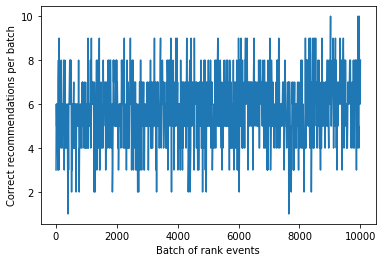

In [34]:
createChart(count,rewards)

In [39]:
#Verify new learning policy and times
get_service_settings()

-----checking service settings
<Response [200]>
{'name': '7b90cd7609c345bca9e27db52868278e', 'arguments': '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr -q Fj -q Fi -l 1 --power_t 0'}
<Response [200]>
{'rewardWaitTime': 'PT5M', 'defaultReward': 0.0, 'rewardAggregation': 'sum', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT5M', 'logRetentionDays': -1}


In [41]:
# max iterations
num_requests = 2000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2)

KeyError: 'rewardActionId'

In [ ]:
createChart(count2,rewards2)